### Model Creation - Multi Layer Perceptron
Paper:  
Sigmoid activation function has been considered in this work
as the non-linear transfer function of each neuron. We utilized the
Scikit-Learn library [32] in Python to create the model

**Imports:**

In [2]:
import torch
import csv
from torch.utils.data import random_split
from matplotlib import pyplot



#### Dataset Loading

In [3]:
def dataset(dataset_file, delimiter=";"):
    
  # read dataset
  data = []
  
  with open(dataset_file, 'r') as f:
    reader = csv.reader(f, delimiter=delimiter)
    next(reader)  # Skip the header row
    for line in reader:
      data.append([float(elem) for elem in line])
              
  print (f"Loaded dataset with {len(data)} samples")
  
  # convert to torch.tensor
  data_tensor = torch.tensor(data, dtype=torch.float)

  # get the input (data samples) without the target information
  X = data_tensor[:, :-1]
  
  T = data_tensor[:, -1].to(torch.float)
  T = T.view(T.shape[0], 1)
  
  return X, T

#### Split Training and Validation Data

In [4]:
def split_training_data(X, T, train_percentage=0.8):
  
  assert len(X) == len(T)
  
  num_samples = len(X)
  
  train_size = int(train_percentage * num_samples)
  validation_size = num_samples - train_size
    
  # split into 80/20 training/validation
  idx_train, idx_validation = random_split(range(num_samples), [train_size, validation_size])

  
  X_train = X[idx_train]
  T_train = T[idx_train]
  X_val = X[idx_validation]
  T_val = T[idx_validation]

  return X_train, T_train, X_val, T_val

#### Input Data Standardization

In [21]:
def standardize(X_train, X_val):
  # compute statistics
  mean = X_train.mean(dim=0)
  std = X_train.std(dim=0)

  # Check if standard deviation is zero
  zero_std_mask = std == 0
  
  # Standardize both X_train and X_val, excluding columns with zero standard deviation
  X_train = (X_train - mean) / std.masked_fill(zero_std_mask, 1)  # Replace zero std with 1 to avoid division by zero
  X_val = (X_val - mean) / std.masked_fill(zero_std_mask, 1)

  return X_train, X_val

### Network Implementation

**Network Architecture**
- 1 input layer
  - 7 input neurons
- 2 hidden layers
  - 10 hidden neurons
  - 10 hidden neurons
- 1 output layer
  - 1 output neuron    

Using Sigmoid Activation function!

In [6]:
def Network(input_layer_size, hidden_layer_size, output_layer_size):
    return torch.nn.Sequential(
        torch.nn.Linear(input_layer_size, hidden_layer_size),      # Input layer to first hidden layer
        torch.nn.Sigmoid(),                                        # Sigmoid activation function for the first hidden layer
        torch.nn.Linear(hidden_layer_size, hidden_layer_size),     # First hidden layer to second hidden layer
        torch.nn.Sigmoid(),                                        # Sigmoid activation function for the second hidden layer
        torch.nn.Linear(hidden_layer_size, output_layer_size)      # Second hidden layer to output layer
    )

**Training Loop**

In [7]:
def accuracy(Z, T):
  # binary classification
  z_sign = (Z >= 0).int()
  return torch.mean((z_sign == T).float())

In [8]:
def train(network, loss, X_train, T_train, X_val, T_val, num_epochs=10000, learning_rate=0.1):
  
  optimizer = torch.optim.SGD(
    params=network.parameters(),
    lr=learning_rate
  )

  # collect loss and accuracy values
  train_loss, train_acc, val_loss, val_acc = [], [], [], []

  for epoch in range(num_epochs):
    # train on training set
    optimizer.zero_grad()
    # ... compute network output on training data
    Z = network(X_train)
    if Z.shape[1] > 1:
      T_train = torch.flatten(T_train)
    
    # ... compute loss from network output and target data
    J = loss(Z, T_train)
    J.backward()
    # ... perform parameter update
    optimizer.step()
    # ... remember loss
    train_loss.append(J.item())
    # ... compute training set accuracy
    train_acc.append(accuracy(Z, T_train).item())

    # test on validation data
    with torch.no_grad():
      # ... compute network output on validation data
      Z = network(X_val)
      if Z.shape[1] > 1:
        T_val = torch.flatten(T_val)
      # ... compute loss from network output and target data
      J = loss(Z, T_val)
      # ... remember loss
      val_loss.append(J.item())
      # ... compute validation set accuracy
      val_acc.append(accuracy(Z, T_val).item())

  # return the four lists of losses and accuracies
  return train_loss, train_acc, val_loss, val_acc

In [9]:
def plot(train_loss, train_acc, val_loss, val_acc):
  pyplot.figure(figsize=(10,3))
  ax = pyplot.subplot(121)
  ax.plot(train_loss, "g-", label="Training set loss")
  ax.plot(val_loss, "b-", label="Validation set loss")
  ax.legend()

  ax = pyplot.subplot(122)
  ax.plot(train_acc, "g-", label="Training set accuracy")
  ax.plot(val_acc, "b-", label="Validation set accuracy")
  ax.legend()

Loaded dataset with 198 samples


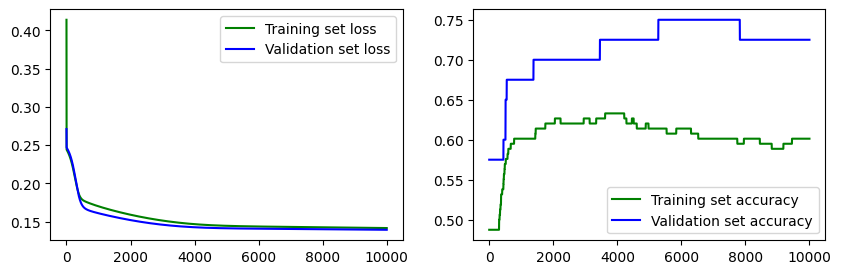

In [27]:
# define loss function
loss = torch.nn.MSELoss()

# load dataset
X, T = dataset("test-data.csv", ",")

# split dataset
X_train, T_train, X_val, T_val = split_training_data(X, T, 0.8)
# standardize input data

X_train, X_val = standardize(X_train, X_val)

# initiate the network
network = Network(7, 10, 1)

# train network on our data
results = train(network, loss, X_train, T_train, X_val, T_val, num_epochs=10000, learning_rate=0.1)

train_loss, train_acc, val_loss, val_acc = results

# plot the results
plot(train_loss, train_acc, val_loss, val_acc)

In [23]:
X_train

tensor([[-0.2912, -0.3247, -0.5992, -0.2772, -0.2675,  0.0000,  0.0000],
        [-0.6171, -0.5399,  1.3781, -0.3648, -0.2675,  0.0000,  0.0000],
        [-0.2055,  0.1623, -0.5617, -0.2541, -0.2675,  0.0000,  0.0000],
        [-0.4628, -0.4620, -0.4801, -0.3233, -0.2675,  0.0000,  0.0000],
        [-0.5314, -0.6275, -0.3230, -0.3440, -0.2644,  0.0000,  0.0000],
        [ 3.2376,  2.4003,  2.8170,  3.4578,  3.4744,  0.0000,  0.0000],
        [-0.3942, -0.6229, -0.5791, -0.3048, -0.2675,  0.0000,  0.0000],
        [ 0.4291, -0.6497, -0.4824, -0.0834, -0.2675,  0.0000,  0.0000],
        [ 0.2473,  1.1426, -0.2717, -0.1323, -0.2675,  0.0000,  0.0000],
        [-0.4628, -0.5163, -0.4394, -0.3233, -0.2675,  0.0000,  0.0000],
        [-0.4799, -0.4531, -0.3125, -0.3279, -0.2675,  0.0000,  0.0000],
        [ 0.4735,  1.6983,  0.8501, -0.0715, -0.2675,  0.0000,  0.0000],
        [-0.4628, -0.5441, -0.4513, -0.3233, -0.2675,  0.0000,  0.0000],
        [-0.4799, -0.6634, -0.5449, -0.3279, -0.267